In [1]:
import tensorflow as tf
import pandas as pd

from FeedBack import FeedBack
from window import WindowGenerator
from utils import train_test_val_split

# RNN

## Dataset

In [2]:
case_1 = pd.read_csv("datasets/case_1.csv")
case_2 = pd.read_csv("datasets/case_2.csv")
case_3 = pd.read_csv("datasets/case_3.csv")
case_4 = pd.read_csv("datasets/case_4.csv")
case_5 = pd.read_csv("datasets/case_5.csv")

In [3]:
outlets = [ col for col in case_1.columns.values if col.startswith('outlet') ]
label_columns = outlets
feature_count = len(case_1.columns)

In [4]:
column_indices = { name: i for i, name in enumerate(case_1.columns) }

## Train case function

In [5]:
def train_case(case_df:pd.DataFrame, model:FeedBack, in_width:int, out_steps:int, max_epochs:int):
    """ Train model for given case df. """

    outlets = [ col for col in case_df.columns.values if col.startswith('outlet') ]
    column_indices = { name: i for i, name in enumerate(case_df.columns) }

    train_df, test_df, val_df = train_test_val_split(case_df)
    # train_df, test_df, val_df = normalize_datasets(train_df, test_df, val_df)
    # print(train_df.shape)
    # print(test_df.shape)
    # print(val_df.shape)

    label_columns = outlets

    multi_window = WindowGenerator(
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        input_width=in_width,
        label_width=out_steps,
        shift=out_steps,
        # label_columns=label_columns
    )

    # prediction, state = model.warmup(multi_window.example[0])
    # print(prediction.shape)

    # print(multi_window.example[0].shape)
    # print('Output shape (batch, time, features): ', model(multi_window.example[0]).shape)

    history = model.fit(
        multi_window.train,
        epochs=max_epochs,
        validation_data=multi_window.val,
        verbose=100
        # callbacks=[early_stopping]
    )

    return multi_window, history

## Model creation

In [6]:
IN_WIDTH = 8
OUT_STEPS = 8
MAX_EPOCHS = 20
features_size = len(label_columns)

In [7]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS, num_features=feature_count)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-08-18 11:57:30.945754: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-18 11:57:30.945845: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2022-08-18 11:57:31.087080: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Total window size: 16
Input indices: [0 1 2 3 4 5 6 7]
Label indices: [ 8  9 10 11 12 13 14 15]
Label column name(s): None

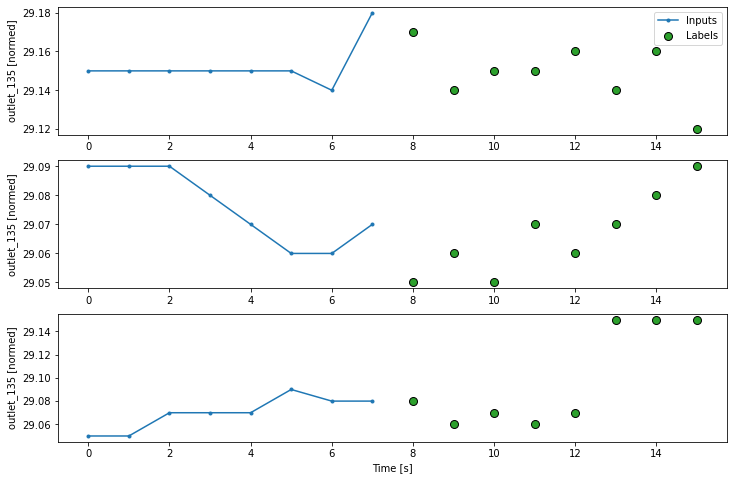

In [8]:
outlets = [ col for col in case_1.columns.values if col.startswith('outlet') ]
column_indices = { name: i for i, name in enumerate(case_1.columns) }

train_df, test_df, val_df = train_test_val_split(case_1)
# train_df, test_df, val_df = normalize_datasets(train_df, test_df, val_df)
# print(train_df.shape)
# print(test_df.shape)
# print(val_df.shape)

label_columns = outlets

# print(train_df.head())
multi_window = WindowGenerator(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    input_width=IN_WIDTH,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    # label_columns=label_columns
)

multi_window.plot()
multi_window

In [9]:
feedback_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.RootMeanSquaredError()])

In [10]:
prediction, state = feedback_model.warmup(multi_window.example[0])
print(prediction.shape)
print(multi_window.example[0].shape)
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

(32, 272)
(32, 8, 272)
Output shape (batch, time, features):  (32, 8, 272)


In [11]:
window, history = train_case(
    case_df=case_1,
    model=feedback_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

Epoch 1/20


2022-08-18 11:57:32.407495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-18 11:57:34.737906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


In [12]:
print('Output shape (batch, time, features): ', feedback_model(window.example[0]).shape)

Output shape (batch, time, features):  (32, 8, 272)


In [13]:
tf.keras.utils.plot_model(feedback_model, "feedback_model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


2022-08-18 11:57:45.540746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


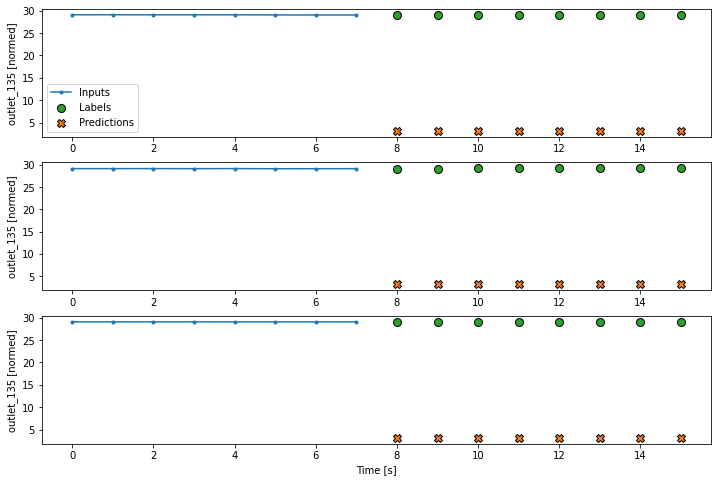

In [14]:
window.plot(feedback_model, plot_col="outlet_135")

In [15]:
losses = pd.DataFrame(history.history)

<AxesSubplot:title={'center':'Model loss'}, xlabel='Epoch', ylabel='Loss'>

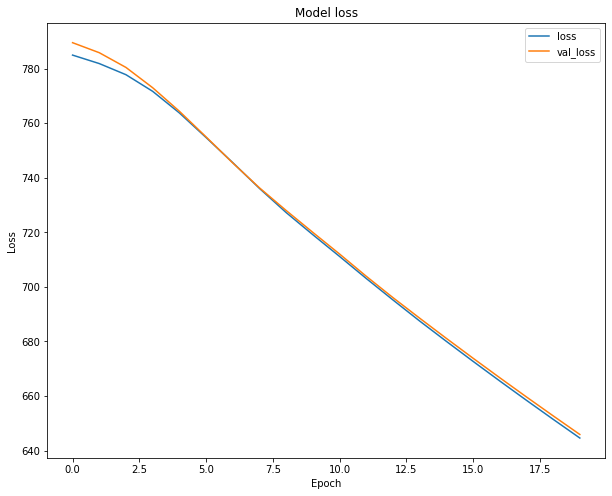

In [16]:
losses[['loss', 'val_loss']].plot(figsize=(10,8), xlabel="Epoch", ylabel="Loss", title="Model loss")

<AxesSubplot:title={'center':'RMSE'}, xlabel='Epoch', ylabel='RMSE'>

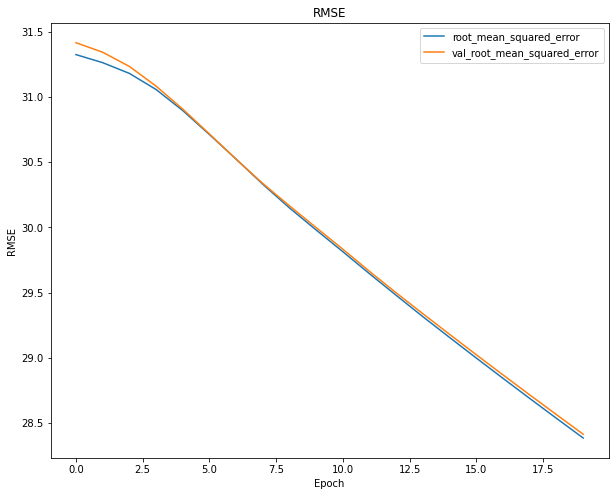

In [17]:
losses[['root_mean_squared_error', 'val_root_mean_squared_error']].plot(figsize=(10,8), xlabel="Epoch", ylabel="RMSE", title="RMSE")

In [18]:
feedback_model.evaluate(window.test)

1/1 [==============================] - 0s 196ms/step - loss: 645.4219 - root_mean_squared_error: 28.4012


[645.421875, 28.401195526123047]